<a href="https://colab.research.google.com/github/singhsourav0/Deep-Learning-Odyssey/blob/main/GRU_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emotions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4403839%2F7563141%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T175913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D579650748ea0bf8f8d5fa5275d96f9ef1011a8b5782b581c2d4daa45282b6e9f7186d2fda3549ed6f5888cccbb30a143fe753644d26eba5fe9fe1a33a40295774274ae698c061205f7bdc53d85af8466214d3a11f132a3931555cdbddeff1ac08cf22d7fd3169c6ce450d082775e1a6baa5cec192ddb08d65050e337469335cb1895078818a2d518dd349f06ab729b6fd89bde86dc2d21ac9f4c7938c630b951125c12dbee0a4257c4d1a198604898bf36f36e09d3a9f85ec61db8cf4b482b06f2cc8ec27cf07f28d573efa2045897dd5193a2e21fc75c90c35f9ff49369c487a8b9a98e0204364b3882a66b4276d8c413c8e3a603594dbc9882335a847965ee'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16440679 bytes downloaded
Downloaded and uncompressed: emotions
Data source import complete.


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/emotions/text.csv


In [3]:
df=pd.read_csv('/kaggle/input/emotions/text.csv')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [6]:
df.duplicated().sum()

0

In [7]:
df = df.drop_duplicates()

In [8]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'

}

df['label'] = df['label'].map(emotion_map)

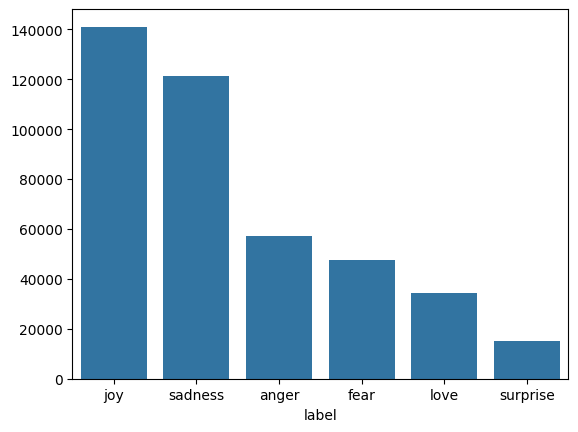

In [9]:
count=df['label'].value_counts()
sns.barplot(x=count.index, y=count.values)
plt.show()

In [10]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,fear
1,1,ive enjoyed being able to slouch about relax a...,sadness
2,2,i gave up my internship with the dmrg and am f...,fear
3,3,i dont know i feel so lost,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,fear


In [11]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,Unnamed: 0,text,label
0,0,feel really helpless heavy hearted,fear
1,1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,2,gave internship dmrg feeling distraught,fear
3,3,dont know feel lost,sadness
4,4,kindergarten teacher thoroughly weary job take...,fear


In [12]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df['text'] = df['text'].str.lower()
print(df.head())

   Unnamed: 0                                               text    label
0           0                 feel really helpless heavy hearted     fear
1           1  ive enjoyed able slouch relax unwind frankly n...  sadness
2           2            gave internship dmrg feeling distraught     fear
3           3                                dont know feel lost  sadness
4           4  kindergarten teacher thoroughly weary job take...     fear


In [13]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
df.head()

,Unnamed: 0,text,label
0,0,feel really helpless heavy hearted,fear
1,1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,2,gave internship dmrg feeling distraught,fear
3,3,dont know feel lost,sadness
4,4,kindergarten teacher thoroughly weary job take...,fear


In [14]:
label_mapping = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4,'surprise':5}


df['label'] = df['label'].map(label_mapping)

In [15]:
from sklearn.model_selection import train_test_split
X=df['text']
y=df['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [17]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

Maximum sequence length (maxlen): 79


In [18]:
input_size = np.max(X_train_padded) + 1
input_size

60000

In [19]:
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

# Add a bidirectional GRU layer with 128 units
model.add(Bidirectional(LSTM(128)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(6, activation='softmax'))

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 100)           6000000   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [21]:
history = model.fit(X_train_padded, y_train, epochs=3, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/3
10421/10421 [==============================] - 177s 16ms/step - loss: 0.2261 - accuracy: 0.9049 - val_loss: 0.0983 - val_accuracy: 0.9397
Epoch 2/3
10421/10421 [==============================] - 160s 15ms/step - loss: 0.1063 - accuracy: 0.9377 - val_loss: 0.0947 - val_accuracy: 0.9405
Epoch 3/3
10421/10421 [==============================] - 140s 13ms/step - loss: 0.0999 - accuracy: 0.9398 - val_loss: 0.0930 - val_accuracy: 0.9408


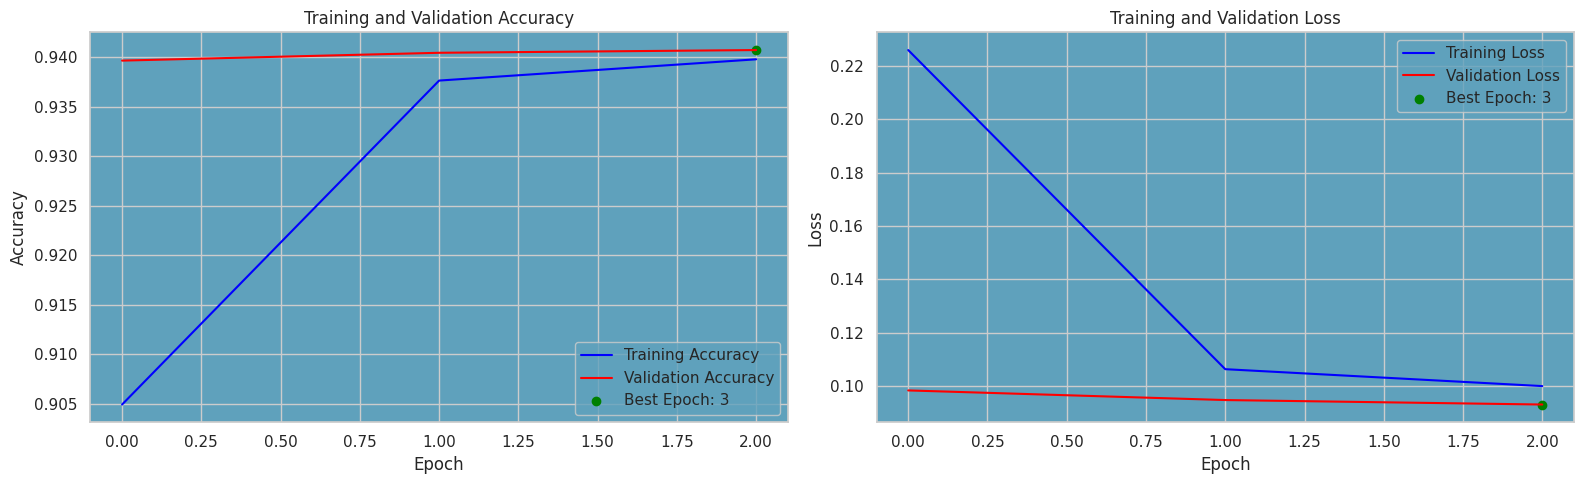

In [22]:
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


In [23]:
model.evaluate(X_test_padded, y_test)

2606/2606 [==============================] - 13s 5ms/step - loss: 0.0930 - accuracy: 0.9408


[0.09298932552337646, 0.940752387046814]

In [25]:
text = "I am so bad today!"
# Convert the text to a sequence
text_sequence = tokenizer.texts_to_sequences([text])
# Pad the sequence
padded_sequence = pad_sequences(text_sequence, maxlen=maxlen, padding='post')
# Predict the emotion
predicted_emotion = np.argmax(model.predict(padded_sequence))
# Print the predicted emotion
print(f"Predicted emotion: {emotion_map[predicted_emotion]}")


1/1 [==============================] - 0s 20ms/step
Predicted emotion: sadness
